# Comparison of Distributions and Repository Selection

This project compares the distribution (stars, age, etc.) of DS repos and Non-DS repos, and selects the final repo ids to include in each set for the rest of the analysis.

Dependencies:
* analyse_py_ver notebook (`ds_version_tab.csv`, `nonds_version_tab.csv`)

Inputs:
* `github_api.csv` (for boa DS repos, and non-DS repos)

Outputs:
* `ds_selected.csv`, `nonds_selected.csv`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from os.path import join

In [2]:
DATA_DIR = "../output/"
NB_OUT = join(DATA_DIR, "notebooks_out")
MERGED_DIR = join(DATA_DIR, "merged")

# Load Python Version Data

In [3]:
ds_version_tab = pd.read_csv(join(NB_OUT, "ds_version_tab.csv"))
nonds_version_tab = pd.read_csv(join(NB_OUT, "nonds_version_tab.csv"))

# Load LOC Data

In [4]:
results_loc = pd.read_csv(join(MERGED_DIR, "results_loc.csv"))
results_loc["loc"] = results_loc["nonblank_loc"] # Radon SLOC hung, so used `wc` to get non-blank LOC instead.
results_loc_grouped = results_loc.groupby("repo").agg({"loc": np.sum})

In [5]:
results_loc.internal_error.value_counts(dropna=False)

False    236107
True        155
Name: internal_error, dtype: int64

In [6]:
results_loc[results_loc["internal_error"]].nonblank_loc.value_counts(dropna=False)

NaN    155
Name: nonblank_loc, dtype: int64

In [7]:
results_loc[(results_loc["internal_error"] == True) & ~results_loc["path"].str.contains("env") & ~results_loc["path"].str.contains("lib")]

,repo,path,nonblank_loc,internal_error,loc
26431,97159209,97159209/Math_Tutorials/Riemannian_Geometry_ML...,NaN,True,NaN
26441,97159209,97159209/Math_Tutorials/Riemannian_Geometry_ML...,NaN,True,NaN
75156,26083875,26083875/tfidf/framework.py,NaN,True,NaN
75186,26083875,26083875/describe/framework.py,NaN,True,NaN
85433,3882212,3882212/rae/pyparse.py,NaN,True,NaN
85435,3882212,3882212/rae/pypm.py,NaN,True,NaN
150630,65145354,65145354/setup.py,NaN,True,NaN
212800,42882329,42882329/pupy/packages/linux/all/mimipy.py,NaN,True,NaN


Internal errors will be treated as NaN (will be treated as 0 file size for purpose of LOC calc. Most are external libraries (in (v)env or lib, thus probably broken symlinks). The remaining are either broken symlinks or in one case due to a filename that ended in a space:

```
~/Data/cloned-repos/boa/97159209/Math_Tutorials/Riemannian_Geometry_ML_DL_Applications/1. Bayesian Statistical Shape Analysis Manifold Diffeomorphism $ cat __init__.py 
cat: __init__.py: No such file or directory
```

In [8]:
results_loc_grouped

,loc
repo,
118130,6090.0
192904,43064.0
329033,67171.0
379988,7496.0
462713,7254.0
...,...
220350524,2185.0
222271895,6798.0
234515221,8495.0


# Load Cyclomatic Complexity Data

In [9]:
df_cc3 = pd.read_csv(join(MERGED_DIR, "results_radon_cc_python3.csv"))
df_cc_combo_filt = df_cc3[df_cc3["type"].isin(["method", "function"])]

In [10]:
df_cc3.type.value_counts()

method      1358317
function     492695
class        307218
Name: type, dtype: int64

In [11]:
df_cc_combo_filt.parse_error.value_counts(dropna=False)

False    1851012
Name: parse_error, dtype: int64

In [12]:
df_cc_combo_filt.internal_error.value_counts(dropna=False)

False    1851012
Name: internal_error, dtype: int64

The cyclomatic complexity results don't include any errors (for methods/functions)

In [13]:
df_cc_grouped = pd.DataFrame(df_cc_combo_filt.groupby(["repo"]).mean()["complexity"])

In [14]:
df_cc_grouped

,complexity
repo,
118130,3.455782
192904,2.598944
329033,3.361554
379988,2.788260
462713,3.892857
...,...
220350524,3.488095
222271895,2.085526
234515221,3.033771


# Load Git Commit Date Data

In [15]:
df_git = pd.read_csv(join(MERGED_DIR, "results_git_date.csv"))

In [16]:
df_git["age"] = (df_git["last_committed_date"] - df_git["first_committed_date"]) / 86400 # 86400 seconds per day in unix time

In [17]:
df_git

,repo,first_committed_date,first_committed_datetime,first_authored_date,first_authored_datetime,last_committed_date,last_committed_datetime,last_authored_date,last_authored_datetime,git_error,age
0,190000321,1.498845e+09,2017-06-30T19:54:56+02:00,1.498845e+09,2017-06-30T19:54:56+02:00,1.559565e+09,2019-06-03T14:28:34+02:00,1.559565e+09,2019-06-03T14:28:34+02:00,False,702.773356
1,160251929,1.543875e+09,2018-12-03T14:04:23-08:00,1.543873e+09,2018-12-03T13:30:37-08:00,1.583454e+09,2020-03-06T00:15:52+00:00,1.583448e+09,2020-03-05T22:46:41+00:00,False,458.091308
2,159175746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
3,159004094,1.543127e+09,2018-11-25T14:22:22+08:00,1.543127e+09,2018-11-25T14:22:22+08:00,1.581000e+09,2020-02-06T22:47:57+08:00,1.581000e+09,2020-02-06T22:47:57+08:00,False,438.351100
4,157936206,1.541528e+09,2018-11-06T10:21:34-08:00,1.541528e+09,2018-11-06T10:21:34-08:00,1.584077e+09,2020-03-12T22:28:35-07:00,1.584077e+09,2020-03-12T22:28:06-07:00,False,492.463206
...,...,...,...,...,...,...,...,...,...,...,...
4024,38397048,1.435788e+09,2015-07-01T23:54:40+02:00,1.435788e+09,2015-07-01T23:54:40+02:00,1.435846e+09,2015-07-02T16:01:11+02:00,1.435846e+09,2015-07-02T16:01:11+02:00,False,0.671192
4025,38386331,1.274796e+09,2010-05-25T16:05:19+02:00,1.274796e+09,2010-05-25T16:05:19+02:00,1.582796e+09,2020-02-27T10:32:50+01:00,1.582796e+09,2020-02-27T10:32:50+01:00,False,3564.810775
4026,38377985,1.435764e+09,2015-07-01T17:11:55+02:00,1.435764e+09,2015-07-01T17:11:55+02:00,1.577727e+09,2019-12-30T18:26:13+01:00,1.577727e+09,2019-12-30T18:26:13+01:00,False,1643.093264
4027,38355280,1.435734e+09,2015-07-01T09:58:27+03:00,1.435734e+09,2015-07-01T09:58:27+03:00,1.504010e+09,2017-08-29T15:33:51+03:00,1.504010e+09,2017-08-29T15:33:51+03:00,False,790.232917


Age is unknown (NaN) for repos extracted from zip files (rather than git). This is the case for 6 of the DS repos, but wasn't an issue for any of the selected non-DS repos.

# Load DS Data

In [18]:
ds = pd.read_csv("../data/boa/github_api.csv", parse_dates=['created_at', 'updated_at', 'pushed_at'])

In [19]:
ds_all_ids = set(ds["id"])

In [20]:
ds.shape

(1552, 16)

In [21]:
blacklisted = set([858127]) # Pandas (blacklisted from analysis because it causes Pylint to hang)

In [22]:
ds = ds[~ds["id"].isin(blacklisted)]

In [23]:
ds.shape

(1551, 16)

In [24]:
ds = ds.merge(df_git, how='left', left_on=['id'], right_on=['repo'])

In [25]:
ds = ds.merge(ds_version_tab, how='left', left_on=['id'], right_on=['repo'])

In [26]:
ds = ds.merge(results_loc_grouped, how='left', left_on=['id'], right_on=['repo'])

In [27]:
ds = ds.merge(df_cc_grouped, how='left', left_on=['id'], right_on=['repo'])

In [28]:
ds

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity
0,87245489,BEGAN,artcg/BEGAN,https://api.github.com/repos/artcg/BEGAN,https://github.com/artcg/BEGAN,195,2017-04-04 23:43:08+00:00,2020-02-17 15:00:24+00:00,2018-03-16 02:56:27+00:00,1295,...,345.134225,87245489.0,8.0,0.0,0.0,0.0,either,True,541.0,2.600000
1,38509215,bat-country,jrosebr1/bat-country,https://api.github.com/repos/jrosebr1/bat-country,https://github.com/jrosebr1/bat-country,240,2015-07-03 20:19:21+00:00,2019-11-23 02:16:57+00:00,2019-10-22 14:42:24+00:00,9199,...,32.154988,38509215.0,7.0,0.0,0.0,0.0,either,True,318.0,3.000000
2,77967300,chatbot-rnn,pender/chatbot-rnn,https://api.github.com/repos/pender/chatbot-rnn,https://github.com/pender/chatbot-rnn,785,2017-01-04 01:11:49+00:00,2020-02-29 07:03:43+00:00,2018-02-04 17:41:59+00:00,2741,...,396.687488,77967300.0,2.0,0.0,0.0,3.0,only3,True,1143.0,4.480769
3,100753000,poeai,nicholastoddsmith/poeai,https://api.github.com/repos/nicholastoddsmith...,https://github.com/nicholastoddsmith/poeai,136,2017-08-18 21:56:06+00:00,2020-02-28 14:15:28+00:00,2019-05-09 20:10:30+00:00,3644,...,532.227894,100753000.0,7.0,0.0,0.0,1.0,only3,True,1312.0,2.543103
4,117555776,open-solution-data-science-bowl-2018,minerva-ml/open-solution-data-science-bowl-2018,https://api.github.com/repos/minerva-ml/open-s...,https://github.com/minerva-ml/open-solution-da...,151,2018-01-15 14:30:27+00:00,2020-02-14 21:22:36+00:00,2019-10-23 16:40:19+00:00,7356,...,646.087905,117555776.0,29.0,0.0,0.0,4.0,only3,True,5034.0,2.033264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,47376247,hierarchical-encoder-decoder,lipiji/hierarchical-encoder-decoder,https://api.github.com/repos/lipiji/hierarchic...,https://github.com/lipiji/hierarchical-encoder...,99,2015-12-04 02:39:22+00:00,2019-12-15 00:22:09+00:00,2016-07-21 15:28:46+00:00,17,...,230.344687,47376247.0,10.0,0.0,2.0,0.0,only2,False,667.0,1.766667
1547,66316247,Sequence-Semantic-Embedding,eBay/Sequence-Semantic-Embedding,https://api.github.com/repos/eBay/Sequence-Sem...,https://github.com/eBay/Sequence-Semantic-Embe...,408,2016-08-22 23:43:01+00:00,2020-03-01 22:20:51+00:00,2018-12-24 17:10:48+00:00,188603,...,853.727280,66316247.0,13.0,0.0,0.0,0.0,either,True,2452.0,3.275229
1548,66105249,keras-cam,jacobgil/keras-cam,https://api.github.com/repos/jacobgil/keras-cam,https://github.com/jacobgil/keras-cam,298,2016-08-19 18:52:39+00:00,2020-02-27 02:30:37+00:00,2017-08-05 02:53:50+00:00,459,...,74.680382,66105249.0,1.0,0.0,2.0,0.0,only2,False,141.0,5.000000
1549,130375797,dgl,dmlc/dgl,https://api.github.com/repos/dmlc/dgl,https://github.com/dmlc/dgl,4127,2018-04-20 14:49:09+00:00,2020-03-02 02:57:05+00:00,2020-03-02 05:42:35+00:00,6187,...,695.042662,130375797.0,573.0,0.0,0.0,45.0,only3,True,108935.0,2.853926


In [29]:
ds.shape

(1551, 36)

In [30]:
ds[ds["select"].isna()]

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity
168,124550747,tflite-mnist-android,nex3z/tflite-mnist-android,https://api.github.com/repos/nex3z/tflite-mnis...,https://github.com/nex3z/tflite-mnist-android,166,2018-03-09 14:27:47+00:00,2020-02-17 22:31:45+00:00,2019-04-19 13:26:43+00:00,541,...,403.480220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478,104082465,Custom-Object-Detection,bourdakos1/Custom-Object-Detection,https://api.github.com/repos/bourdakos1/Custom...,https://github.com/bourdakos1/Custom-Object-De...,321,2017-09-19 14:01:52+00:00,2020-02-11 08:51:38+00:00,2019-03-29 15:05:21+00:00,147212,...,556.044039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,131234205,FeatherCNN,Tencent/FeatherCNN,https://api.github.com/repos/Tencent/FeatherCNN,https://github.com/Tencent/FeatherCNN,1042,2018-04-27 02:21:30+00:00,2020-02-28 02:19:38+00:00,2019-09-24 06:34:01+00:00,42745,...,148.886644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Manual inspection of above 3 repos reveals that they have no Python code!

In [31]:
ds = ds[~ds["select"].isna()]

In [32]:
ds.shape

(1548, 36)

In [33]:
ds = ds[ds["select"] == True]

In [34]:
ds.shape

(1048, 36)

In [35]:
ds[~(ds["loc"] > 0)]

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity


In [36]:
ds[~(ds["complexity"] > 0)]

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity
89,104375922,uTensor,uTensor/uTensor,https://api.github.com/repos/uTensor/uTensor,https://github.com/uTensor/uTensor,1087,2017-09-21 17:04:59+00:00,2020-03-02 01:36:35+00:00,2020-02-29 15:20:40+00:00,5199,...,895.976412,104375922.0,1.0,0.0,0.0,0.0,either,True,12.0,NaN
207,113973574,stockprediction,sebastianheinz/stockprediction,https://api.github.com/repos/sebastianheinz/st...,https://github.com/sebastianheinz/stockprediction,443,2017-12-12 10:00:01+00:00,2020-02-17 22:09:46+00:00,2017-12-12 14:16:12+00:00,41689,...,0.177847,113973574.0,1.0,0.0,0.0,0.0,either,True,110.0,NaN
225,73718098,Recurrent-Convolutional-Neural-Network-Text-Cl...,airalcorn2/Recurrent-Convolutional-Neural-Netw...,https://api.github.com/repos/airalcorn2/Recurr...,https://github.com/airalcorn2/Recurrent-Convol...,180,2016-11-14 15:25:37+00:00,2019-12-26 01:13:40+00:00,2018-05-27 16:01:04+00:00,10,...,559.024595,73718098.0,1.0,0.0,0.0,0.0,either,True,55.0,NaN
510,75372369,Kaggle_NCFM,pengpaiSH/Kaggle_NCFM,https://api.github.com/repos/pengpaiSH/Kaggle_...,https://github.com/pengpaiSH/Kaggle_NCFM,235,2016-12-02 07:35:20+00:00,2020-02-28 04:37:25+00:00,2016-12-08 02:28:25+00:00,11,...,5.772523,75372369.0,4.0,0.0,0.0,0.0,either,True,196.0,NaN
543,62509868,Repo-2016,RubensZimbres/Repo-2016,https://api.github.com/repos/RubensZimbres/Rep...,https://github.com/RubensZimbres/Repo-2016,101,2016-07-03 18:31:24+00:00,2020-02-13 18:54:00+00:00,2018-12-10 16:36:35+00:00,5240,...,889.920208,62509868.0,2.0,0.0,0.0,0.0,either,True,69.0,NaN
642,143617378,100-Days-of-ML-Code-Chinese-Version,Avik-Jain/100-Days-of-ML-Code-Chinese-Version,https://api.github.com/repos/Avik-Jain/100-Day...,https://github.com/Avik-Jain/100-Days-of-ML-Co...,2883,2018-08-05 13:58:34+00:00,2020-03-01 20:57:58+00:00,2018-09-10 09:19:35+00:00,2478,...,35.806250,143617378.0,1.0,0.0,0.0,0.0,either,True,62.0,NaN
756,57161533,Deep-Semantic-Similarity-Model,airalcorn2/Deep-Semantic-Similarity-Model,https://api.github.com/repos/airalcorn2/Deep-S...,https://github.com/airalcorn2/Deep-Semantic-Si...,466,2016-04-26 20:59:44+00:00,2020-02-26 09:02:49+00:00,2017-06-05 20:24:23+00:00,22,...,404.975451,57161533.0,1.0,0.0,0.0,0.0,either,True,143.0,NaN
769,35396569,pyDataScienceToolkits_Base,jasonding1354/pyDataScienceToolkits_Base,https://api.github.com/repos/jasonding1354/pyD...,https://github.com/jasonding1354/pyDataScience...,319,2015-05-11 01:59:40+00:00,2020-02-15 02:59:09+00:00,2017-04-17 00:34:09+00:00,1420,...,172.009433,35396569.0,1.0,0.0,0.0,0.0,either,True,34.0,NaN
829,76725259,Repo-2017,RubensZimbres/Repo-2017,https://api.github.com/repos/RubensZimbres/Rep...,https://github.com/RubensZimbres/Repo-2017,1015,2016-12-17 13:21:20+00:00,2020-02-25 20:58:32+00:00,2019-04-22 17:28:08+00:00,42376,...,856.171366,76725259.0,2.0,0.0,0.0,0.0,either,True,124.0,NaN
921,60979461,distributed-tensorflow-example,ischlag/distributed-tensorflow-example,https://api.github.com/repos/ischlag/distribut...,https://github.com/ischlag/distributed-tensorf...,125,2016-06-12 17:13:12+00:00,2019-09-02 00:31:20+00:00,2018-08-01 07:57:10+00:00,9,...,779.613854,60979461.0,1.0,0.0,0.0,0.0,either,True,149.0,NaN


Cases of NaN Cyclomatic Complexity appear to be due to projects without any functions or methods.

In [37]:
ds["id"].to_csv(join(NB_OUT, "ds_selected.csv"), index=False)

# Load Non-DS Data

In [38]:
nonds = pd.read_csv("../data/non-data-science/github_api.csv", parse_dates=['created_at', 'updated_at', 'pushed_at'])

In [39]:
nonds.shape

(9882, 16)

In [40]:
nonds["updated_at"].describe()

count                          9882
unique                         9823
top       2020-03-09 17:06:53+00:00
freq                              4
first     2016-08-02 08:39:59+00:00
last      2020-03-11 18:56:30+00:00
Name: updated_at, dtype: object

Last updated_at date gives us an approximate indication of when the repos were fetched

In [41]:
pd.to_datetime("2020-03-11") - pd.to_datetime("2016-01-01")

Timedelta('1531 days 00:00:00')

In [42]:
dups = set(nonds['id']) & ds_all_ids

In [43]:
dups

{6404963,
 14579099,
 21145960,
 23011147,
 40857800,
 43416021,
 45234875,
 46626681,
 48147779,
 57161533,
 60129104,
 61362743,
 61609586,
 63605558,
 68609247,
 70118622,
 70908208,
 70934951,
 71932349,
 74622643,
 76228721,
 77440857,
 77765629,
 77904282,
 79006723,
 79404479,
 81608592,
 81784084,
 84209477,
 88441301,
 90730179,
 92446304,
 96648397,
 100318313,
 101607701,
 103471501,
 103934044,
 122806629}

In [44]:
len(dups)

38

In [45]:
nonds = nonds[~nonds['id'].isin(dups)]

In [46]:
nonds.shape

(9844, 16)

In [47]:
nonds = nonds.merge(df_git, how='left', left_on=['id'], right_on=['repo'])

In [48]:
nonds = nonds.merge(nonds_version_tab, how='left', left_on=['id'], right_on=['repo'])

In [49]:
nonds = nonds.merge(results_loc_grouped, how='left', left_on=['id'], right_on=['repo'])

In [50]:
nonds = nonds.merge(df_cc_grouped, how='left', left_on=['id'], right_on=['repo'])

In [51]:
#created_thresh = pd.to_datetime('2015-07-01T00:00Z')
created_thresh = pd.to_datetime('2016-01-01T00:00Z')
created_thresh

Timestamp('2016-01-01 00:00:00+0000', tz='UTC')

In [52]:
nonds = nonds[nonds["created_at"] >= created_thresh]
nonds

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity
2,103890505,mythril,ConsenSys/mythril,https://api.github.com/repos/ConsenSys/mythril,https://github.com/ConsenSys/mythril,1332,2017-09-18 04:14:20+00:00,2020-03-05 06:22:15+00:00,2020-03-11 18:27:50+00:00,53149,...,898.143125,103890505.0,97.0,0.0,0.0,88.0,only3,True,16824.0,2.566594
3,101479803,debops,debops/debops,https://api.github.com/repos/debops/debops,https://github.com/debops/debops,596,2017-08-26 10:46:25+00:00,2020-03-11 09:06:12+00:00,2020-03-10 14:43:18+00:00,27105,...,2022.530833,101479803.0,33.0,0.0,0.0,0.0,either,True,6251.0,4.868750
4,49299616,ray,felipevolpone/ray,https://api.github.com/repos/felipevolpone/ray,https://github.com/felipevolpone/ray,216,2016-01-08 22:15:39+00:00,2020-02-27 07:28:51+00:00,2018-03-02 20:49:11+00:00,991,...,783.970278,49299616.0,48.0,0.0,1.0,0.0,only2,False,2098.0,1.665272
17,117024856,adversarial_image_defenses,facebookarchive/adversarial_image_defenses,https://api.github.com/repos/facebookarchive/a...,https://github.com/facebookarchive/adversarial...,412,2018-01-10 23:41:15+00:00,2020-03-02 02:14:28+00:00,2019-01-25 03:24:05+00:00,646,...,365.341481,117024856.0,33.0,0.0,0.0,0.0,either,True,3730.0,4.604938
32,82953176,Decept,Cisco-Talos/Decept,https://api.github.com/repos/Cisco-Talos/Decept,https://github.com/Cisco-Talos/Decept,203,2017-02-23 17:30:12+00:00,2020-02-17 01:33:26+00:00,2019-10-03 19:52:18+00:00,167,...,891.102407,82953176.0,3.0,1.0,8.0,0.0,neither,False,4211.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9820,80370897,Pytorch-Tutorials,alexis-jacq/Pytorch-Tutorials,https://api.github.com/repos/alexis-jacq/Pytor...,https://github.com/alexis-jacq/Pytorch-Tutorials,133,2017-01-29 20:35:36+00:00,2020-02-08 21:00:22+00:00,2018-11-05 16:55:54+00:00,6788,...,644.847431,80370897.0,1.0,0.0,0.0,0.0,either,True,182.0,1.300000
9832,59060289,leather,wireservice/leather,https://api.github.com/repos/wireservice/leather,https://github.com/wireservice/leather,283,2016-05-17 21:26:25+00:00,2020-02-19 20:44:32+00:00,2020-02-05 17:48:05+00:00,331,...,197.236840,59060289.0,60.0,0.0,0.0,0.0,either,True,3189.0,2.023364
9834,90824610,pytorch-classification,bearpaw/pytorch-classification,https://api.github.com/repos/bearpaw/pytorch-c...,https://github.com/bearpaw/pytorch-classification,953,2017-05-10 05:33:36+00:00,2020-03-11 08:54:13+00:00,2019-12-12 21:55:36+00:00,438,...,623.528669,90824610.0,18.0,0.0,0.0,0.0,either,True,1796.0,2.479592
9842,241142684,pg_activity_fork,julmon/pg_activity_fork,https://api.github.com/repos/julmon/pg_activit...,https://github.com/julmon/pg_activity_fork,1,2020-02-17 15:33:13+00:00,2020-02-25 13:57:20+00:00,2020-02-15 07:01:25+00:00,1226,...,2654.546285,241142684.0,5.0,0.0,0.0,0.0,either,True,3036.0,4.951807


In [53]:
nonds.shape

(1627, 36)

In [54]:
nonds[nonds["pushed_at"] < nonds["created_at"]]

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity
532,91692328,lldb.nvim,critiqjo/lldb.nvim,https://api.github.com/repos/critiqjo/lldb.nvim,https://github.com/critiqjo/lldb.nvim,21,2017-05-18 12:46:28+00:00,2020-01-15 04:26:33+00:00,2017-01-05 21:33:49+00:00,604,...,1015.427558,91692328.0,9.0,0.0,1.0,0.0,only2,False,1146.0,3.797619
1278,192239025,pywren,ericmjonas/pywren,https://api.github.com/repos/ericmjonas/pywren,https://github.com/ericmjonas/pywren,2,2019-06-16 21:36:17+00:00,2019-10-30 08:24:29+00:00,2018-11-30 15:41:34+00:00,4306,...,789.923194,192239025.0,54.0,0.0,1.0,0.0,only2,False,7442.0,2.581522
1647,222271895,assertpy,ActivisionGameScience/assertpy,https://api.github.com/repos/ActivisionGameSci...,https://github.com/ActivisionGameScience/assertpy,7,2019-11-17 15:47:15+00:00,2020-02-11 18:48:58+00:00,2019-11-09 12:14:38+00:00,476,...,1779.850914,222271895.0,46.0,0.0,0.0,0.0,either,True,6798.0,2.085526
3248,132427387,eve,nicolaiarocci/eve,https://api.github.com/repos/nicolaiarocci/eve,https://github.com/nicolaiarocci/eve,9,2018-05-07 08:03:04+00:00,2020-01-13 07:51:12+00:00,2018-05-07 07:22:31+00:00,15351,...,2035.974259,132427387.0,65.0,0.0,1.0,0.0,only2,False,18412.0,1.959292
4200,77810699,hunspell-dict-ko,changwoo/hunspell-dict-ko,https://api.github.com/repos/changwoo/hunspell...,https://github.com/changwoo/hunspell-dict-ko,7,2017-01-02 04:27:45+00:00,2020-01-21 18:10:06+00:00,2016-10-01 21:09:19+00:00,1588,...,2859.388611,77810699.0,17.0,0.0,2.0,0.0,only2,False,4084.0,4.129412
4812,124575530,openFEC,18F/openFEC,https://api.github.com/repos/18F/openFEC,https://github.com/18F/openFEC,4,2018-03-09 18:00:20+00:00,2020-01-18 20:35:05+00:00,2018-03-09 17:24:06+00:00,385360,...,1302.926319,124575530.0,103.0,0.0,0.0,3.0,only3,True,18218.0,2.330488
5620,91115384,celery-once,TrackMaven/celery-once,https://api.github.com/repos/TrackMaven/celery...,https://github.com/TrackMaven/celery-once,15,2017-05-12 17:39:08+00:00,2020-02-26 11:54:40+00:00,2016-04-14 17:44:57+00:00,455,...,190.307523,91115384.0,9.0,0.0,0.0,0.0,either,True,425.0,2.063492
5677,149551898,flare-game,clintbellanger/flare-game,https://api.github.com/repos/clintbellanger/fl...,https://github.com/clintbellanger/flare-game,22,2018-09-20 04:37:30+00:00,2020-02-21 14:47:38+00:00,2018-09-17 20:30:00+00:00,848988,...,2662.727211,149551898.0,4.0,0.0,0.0,0.0,either,True,371.0,5.000000
5719,110242469,pyusb,walac/pyusb,https://api.github.com/repos/walac/pyusb,https://github.com/walac/pyusb,78,2017-11-10 12:01:29+00:00,2020-02-29 02:28:50+00:00,2017-11-10 11:25:49+00:00,976,...,3494.523634,110242469.0,25.0,0.0,0.0,0.0,either,True,6877.0,1.808252
6696,179372828,Stein-Variational-Gradient-Descent,DartML/Stein-Variational-Gradient-Descent,https://api.github.com/repos/DartML/Stein-Vari...,https://github.com/DartML/Stein-Variational-Gr...,21,2019-04-03 21:26:28+00:00,2020-03-01 11:12:48+00:00,2019-04-03 21:18:37+00:00,20034,...,988.990394,179372828.0,0.0,0.0,4.0,0.0,only2,False,373.0,NaN


Some non-DS repos were pushed before they were created. (i.e. repo reported as created on github prior to the first push). As these appear to be forks (which should have been excluded), we remove them from the analysis. 

In [55]:
nonds = nonds[nonds["pushed_at"] >= nonds["created_at"]]

In [56]:
nonds.shape

(1613, 36)

In [57]:
nonds = nonds[nonds.age < 1500]

In [58]:
nonds.shape

(1519, 36)

In [59]:
nonds[nonds["age"] < 0]

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity


In [60]:
len(nonds[nonds["age"] < 0])

0

In [61]:
nonds = nonds[nonds["age"] >= 0]

In [62]:
nonds.shape

(1519, 36)

In [63]:
nonds[nonds["select"].isna()]

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity
495,94322193,macOSLAPS,joshua-d-miller/macOSLAPS,https://api.github.com/repos/joshua-d-miller/m...,https://github.com/joshua-d-miller/macOSLAPS,151,2017-06-14 11:10:03+00:00,2020-02-27 08:53:53+00:00,2020-02-11 22:19:14+00:00,772,...,972.464687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560,92646841,api-gateway,restran/api-gateway,https://api.github.com/repos/restran/api-gateway,https://github.com/restran/api-gateway,8,2017-05-28 07:35:15+00:00,2019-12-10 00:06:48+00:00,2017-05-29 04:26:13+00:00,10,...,0.868715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
990,105988412,MultiSigWallet,ConsenSys/MultiSigWallet,https://api.github.com/repos/ConsenSys/MultiSi...,https://github.com/ConsenSys/MultiSigWallet,201,2017-10-06 09:36:23+00:00,2020-02-03 05:50:58+00:00,2018-07-09 20:17:40+00:00,16,...,264.700231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,90704096,ss-panel-and-ss-py-mu,mmmxcc/ss-panel-and-ss-py-mu,https://api.github.com/repos/mmmxcc/ss-panel-a...,https://github.com/mmmxcc/ss-panel-and-ss-py-mu,825,2017-05-09 04:59:18+00:00,2020-03-03 14:30:08+00:00,2019-03-28 04:25:36+00:00,82406,...,583.069676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,86225346,dotfiles,NerdyPepper/dotfiles,https://api.github.com/repos/NerdyPepper/dotfiles,https://github.com/NerdyPepper/dotfiles,322,2017-03-26 10:47:29+00:00,2020-03-03 11:19:34+00:00,2020-02-16 06:29:13+00:00,6712,...,755.979340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1177,70201739,Remove2011,pbowden-msft/Remove2011,https://api.github.com/repos/pbowden-msft/Remo...,https://github.com/pbowden-msft/Remove2011,135,2016-10-06 23:47:18+00:00,2020-02-19 08:09:19+00:00,2019-10-21 16:08:18+00:00,24,...,1109.681238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1488,87855374,Natural_Logic_Interpreter,ParhamP/Natural_Logic_Interpreter,https://api.github.com/repos/ParhamP/Natural_L...,https://github.com/ParhamP/Natural_Logic_Inter...,104,2017-04-10 20:37:39+00:00,2019-12-19 05:26:41+00:00,2018-06-06 17:22:58+00:00,124,...,67.508032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1591,50603581,dockercloud-haproxy,docker-archive/dockercloud-haproxy,https://api.github.com/repos/docker-archive/do...,https://github.com/docker-archive/dockercloud-...,666,2016-01-28 18:24:31+00:00,2020-01-22 23:10:55+00:00,2018-10-01 05:50:43+00:00,324,...,775.163113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1592,84640462,shellsploit-framework,b3mb4m/shellsploit-framework,https://api.github.com/repos/b3mb4m/shellsploi...,https://github.com/b3mb4m/shellsploit-framework,11,2017-03-11 10:02:16+00:00,2020-02-05 08:22:31+00:00,2017-03-11 12:32:00+00:00,0,...,0.103958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798,56612721,stackanetes,stackanetes/stackanetes,https://api.github.com/repos/stackanetes/stack...,https://github.com/stackanetes/stackanetes,224,2016-04-19 16:16:47+00:00,2019-12-18 22:37:48+00:00,2018-04-21 11:31:29+00:00,802,...,731.801829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
nonds = nonds[~nonds["select"].isna()]

In [65]:
nonds.shape

(1462, 36)

In [66]:
nonds = nonds[nonds["select"] == True]

In [67]:
nonds.shape

(1102, 36)

In [68]:
nonds[~(nonds["loc"] > 0)]

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity


In [69]:
nonds[~(nonds["complexity"] > 0)]

,id,name,full_name,url,html_url,stars,created_at,updated_at,pushed_at,size,...,age,repo_y,either,neither,python2,python3,summary,select,loc,complexity
1342,65145354,tensorlayer-chinese,tensorlayer/tensorlayer-chinese,https://api.github.com/repos/tensorlayer/tenso...,https://github.com/tensorlayer/tensorlayer-chi...,349,2016-08-07 17:22:32+00:00,2020-03-10 06:06:02+00:00,2020-02-13 09:02:53+00:00,37845,...,1345.712546,65145354.0,1.0,1.0,0.0,0.0,neither,True,409.0,NaN
2733,125160949,build-webos,webosose/build-webos,https://api.github.com/repos/webosose/build-webos,https://github.com/webosose/build-webos,463,2018-03-14 05:41:02+00:00,2020-03-10 16:43:21+00:00,2020-01-23 02:30:56+00:00,547,...,676.107523,125160949.0,1.0,0.0,0.0,0.0,either,True,77.0,NaN
3908,125710688,AI-ipcam,mharizanov/AI-ipcam,https://api.github.com/repos/mharizanov/AI-ipcam,https://github.com/mharizanov/AI-ipcam,236,2018-03-18 09:43:04+00:00,2020-03-05 02:16:09+00:00,2018-03-23 12:45:34+00:00,188,...,5.126736,125710688.0,1.0,0.0,0.0,0.0,either,True,109.0,NaN
4339,80938356,green-recorder,mhsabbagh/green-recorder,https://api.github.com/repos/mhsabbagh/green-r...,https://github.com/mhsabbagh/green-recorder,567,2017-02-04 18:16:05+00:00,2020-03-11 17:13:41+00:00,2019-08-03 10:38:19+00:00,844,...,909.682106,80938356.0,1.0,0.0,0.0,0.0,either,True,25.0,NaN
4481,50586079,ncTelegram,Nanoseb/ncTelegram,https://api.github.com/repos/Nanoseb/ncTelegram,https://github.com/Nanoseb/ncTelegram,255,2016-01-28 13:51:13+00:00,2020-03-11 07:38:50+00:00,2018-11-05 19:23:00+00:00,206,...,1006.172928,50586079.0,1.0,0.0,0.0,0.0,either,True,14.0,NaN
5085,62723181,ddgr,jarun/ddgr,https://api.github.com/repos/jarun/ddgr,https://github.com/jarun/ddgr,1746,2016-07-06 13:30:54+00:00,2020-03-10 23:06:43+00:00,2020-02-03 14:44:45+00:00,531,...,1307.050231,62723181.0,1.0,0.0,0.0,0.0,either,True,46.0,NaN
5491,57593137,Instant-Movie-Streamer,yask123/Instant-Movie-Streamer,https://api.github.com/repos/yask123/Instant-M...,https://github.com/yask123/Instant-Movie-Streamer,351,2016-05-01 09:49:03+00:00,2020-02-24 17:18:28+00:00,2017-10-17 19:02:48+00:00,23,...,262.019931,57593137.0,2.0,0.0,0.0,0.0,either,True,14.0,NaN
5847,67548976,camomilla,SuperV1234/camomilla,https://api.github.com/repos/SuperV1234/camomilla,https://github.com/SuperV1234/camomilla,114,2016-09-06 21:42:58+00:00,2020-02-05 20:58:56+00:00,2020-01-30 16:28:58+00:00,147,...,1240.781933,67548976.0,1.0,0.0,0.0,0.0,either,True,10.0,NaN
5915,70874657,lptrace,khamidou/lptrace,https://api.github.com/repos/khamidou/lptrace,https://github.com/khamidou/lptrace,655,2016-10-14 04:40:20+00:00,2020-03-05 02:57:02+00:00,2018-10-26 07:37:03+00:00,27,...,133.488542,70874657.0,1.0,0.0,0.0,0.0,either,True,14.0,NaN
6301,64901614,SMS-BOMBER,jdleo/SMS-BOMBER,https://api.github.com/repos/jdleo/SMS-BOMBER,https://github.com/jdleo/SMS-BOMBER,67,2016-08-04 04:09:32+00:00,2020-03-09 03:00:19+00:00,2018-07-08 23:43:49+00:00,22,...,703.815451,64901614.0,1.0,0.0,0.0,0.0,either,True,23.0,NaN


In [70]:
nonds["id"].to_csv(join(NB_OUT, "nonds_selected.csv"), index=False)

## Analyse Language

In [71]:
ds["age"].describe()

count    1044.000000
mean      670.656683
std       594.037613
min         0.000000
25%       265.507607
50%       576.019954
75%       910.221068
max      4964.841528
Name: age, dtype: float64

In [72]:
ds["language"].value_counts() / ds.shape[0]

Python              0.981870
Jupyter Notebook    0.010496
HTML                0.001908
JavaScript          0.001908
C++                 0.000954
Perl                0.000954
C#                  0.000954
Jsonnet             0.000954
Name: language, dtype: float64

In [73]:
ds.shape

(1048, 36)

In [74]:
nonds["language"].value_counts() / nonds.shape[0]

Python              0.941924
Jupyter Notebook    0.017241
JavaScript          0.009074
HTML                0.006352
Shell               0.005445
C++                 0.002722
C#                  0.001815
YARA                0.001815
C                   0.001815
PowerShell          0.000907
Roff                0.000907
Rust                0.000907
CSS                 0.000907
TeX                 0.000907
PLpgSQL             0.000907
Java                0.000907
Smarty              0.000907
Go                  0.000907
Lua                 0.000907
Name: language, dtype: float64

In [75]:
nonds["age"].describe()

count    1102.000000
mean      742.885217
std       440.845383
min         0.000000
25%       361.823142
50%       795.183669
75%      1115.303492
max      1496.816458
Name: age, dtype: float64

## Analyse Distributions

In [76]:
def plot_all_log(dim):
    xs1 = ds[dim]
    xs2 = nonds[dim]
    ks = stats.ks_2samp(xs1, xs2) # calculate before any manipulation
    
    stats.ks_2samp(xs1, xs2)
    # Can't plot 0 on a log scale. So replace 0 (and NaN) with 0.9
    MIN = 0.9
    xs1 = np.where(xs1 > MIN, xs1, MIN)
    xs2 = np.where(xs2 > MIN, xs2, MIN)
    start = min(np.min(xs1), np.min(xs2))
    end = max(np.max(xs1), np.max(xs2))
    logbins = np.logspace(np.log10(start),np.log10(end)+0.001,1000)
    
    plt.hist(xs1, bins=logbins, density=True, histtype='step', cumulative=-1, label='ds')
    plt.hist(xs2, bins=logbins, density=True, histtype='step', cumulative=-1, label='non-ds', ls='--')
    plt.xscale('log')
    #plt.title(dim)
    plt.xlabel(dim.replace('_', ' '))
    plt.xlim(start, end)
    plt.ylabel('survival (1 - CDF)')
    plt.legend(loc='upper right')
    plt.savefig(join(NB_OUT, dim + '-cdf-cutoff-log.png'), dpi=300)
    plt.show()
    
    return ks

In [77]:
def plot_all_lin(dim, unit=''):
    xs1 = ds[dim]
    xs2 = nonds[dim]
    start = min(np.min(xs1), np.min(xs2))
    end = max(np.max(xs1), np.max(xs2))
    linbins = np.linspace(start, end+0.001,1000)
    
    # adapted from https://matplotlib.org/3.1.1/gallery/statistics/histogram_cumulative.html
    plt.hist(xs1, bins=linbins, density=True, histtype='step', cumulative=-1, label='ds')
    plt.hist(xs2, bins=linbins, density=True, histtype='step', cumulative=-1, label='non-ds', ls='--')
    #plt.title(dim)
    plt.xlabel(dim.replace('_', ' ') + unit)
    plt.xlim(start, end)
    plt.ylabel('survival (1 - CDF)')
    plt.legend(loc='upper right')
    plt.savefig(join(NB_OUT, dim + '-cdf-cutoff.png'), dpi=300)
    plt.show()
    
    return stats.ks_2samp(xs1, xs2)

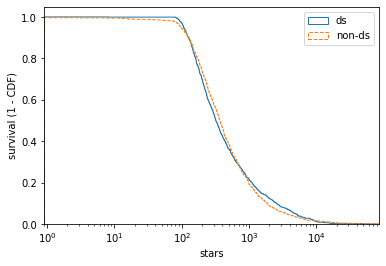

Ks_2sampResult(statistic=0.06193977639545033, pvalue=0.030616614412864784)


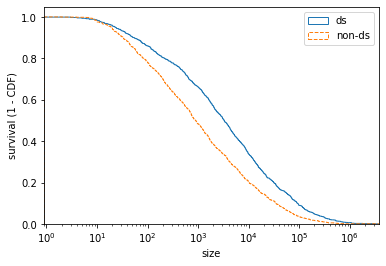

Ks_2sampResult(statistic=0.1891391086296948, pvalue=0.0)


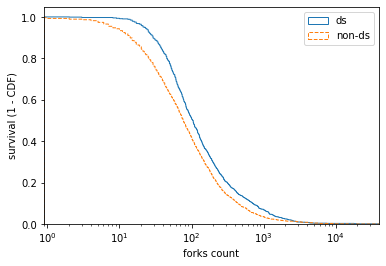

Ks_2sampResult(statistic=0.15259382663027665, pvalue=2.179223468345981e-11)


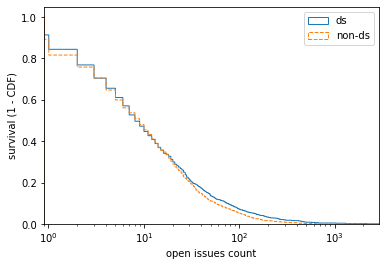

Ks_2sampResult(statistic=0.030840872251700586, pvalue=0.670095850021733)


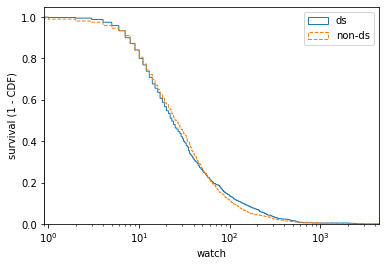

Ks_2sampResult(statistic=0.04415289342070628, pvalue=0.23616063843987745)


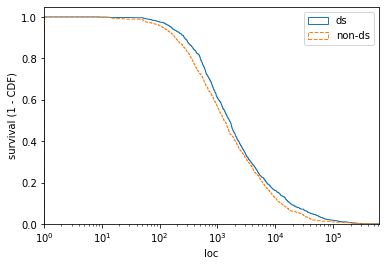

Ks_2sampResult(statistic=0.08649090480874469, pvalue=0.0005934822318574007)


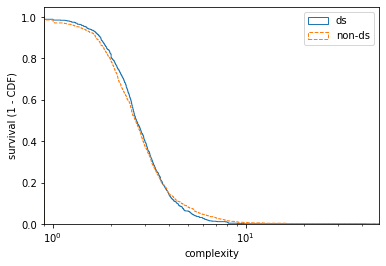

Ks_2sampResult(statistic=0.0577541181197268, pvalue=0.05266706522135056)


In [78]:
dims = ['stars', 'size', 'forks_count', 'open_issues_count', 'watch', 'loc', 'complexity']
for dim in dims:
    print(plot_all_log(dim))

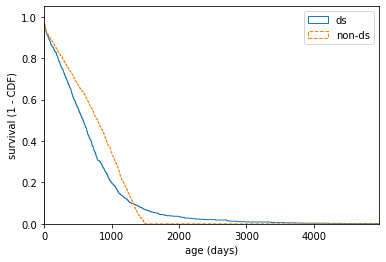

Ks_2sampResult(statistic=0.19165362075892547, pvalue=0.0)

In [79]:
plot_all_lin('age', ' (days)')

NAs will be ignored, so zip repos won't be included in above plot (we assume they follow the same distribution) 

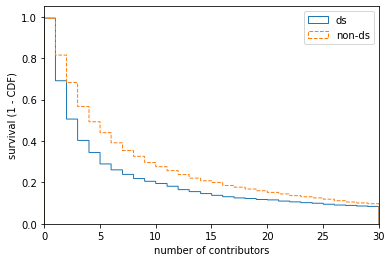

Ks_2sampResult(statistic=0.17667045344342694, pvalue=3.6637359812630166e-15)

In [80]:
plot_all_lin('number_of_contributors')